## Imports

In [107]:
import numpy as np
from astropy.table import Table
import sys
import os
import astropy.io.fits as fits
import argparse as ap
from astropy.time import Time
from astropy.coordinates import (SkyCoord, EarthLocation)
import astropy.units as u
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import lightkurve as lk
import juliandate as jd
from scipy.stats import sem

## Filepaths

In [108]:
#ztf import
ztf_file = '/Users/shaunparasher/Documents/VS Code/denison_2026_test/shaun/Data/ZTF Data/lc_samiclagn.fits'
ztf_data = fits.open(ztf_file)[1].data

#atlas import
filepath = '/Users/shaunparasher/Documents/VS Code/denison_2026_test/shaun/Data/ATLAS data/job3635727.txt'
catt = []
with open(filepath, 'r') as atlas:

    for i in atlas:
        catt.append(i.split())
    
    cat = np.array(catt)

    o_cat = np.array([])

    mask = (cat[:, 5] == 'o')
    o_cat = cat[mask]


#assasn import
i1 = pd.read_csv('/Users/shaunparasher/Documents/VS Code/denison_2026_test/shaun/Data/ASASSN/asassn_diff_image_lightcurve.csv')
i2 = pd.read_csv('/Users/shaunparasher/Documents/VS Code/denison_2026_test/shaun/Data/ASASSN/asassn_diff_image_added_lightcurve.csv')
i3 = pd.read_csv('/Users/shaunparasher/Documents/VS Code/denison_2026_test/shaun/Data/ASASSN/asassn_image_lightcurve.csv')

#plotting both bands for assasn
i1_V = i1[i1['Filter'] == 'V']
i1_g = i1[i1['Filter'] == 'g']

subset1 = i1_g
band1 = 'g'
subset2 = i1_V
band2 = 'V'

## ASSASN g band Lightcurve

We plot the ASSASN data in the g band

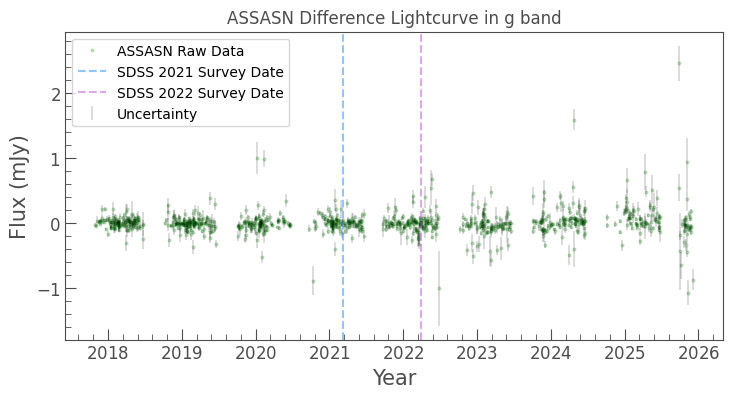

In [109]:
t_years = Time(subset1['HJD'], format='jd').decimalyear
curve = lk.LightCurve(time=t_years, flux=subset1['flux(mJy)'], flux_err=subset1['flux_err'])
ax = curve.plot(alpha=0.2, color='green', label='ASSASN Raw Data', linestyle='none', marker='o')
curve.errorbar(ax=ax, color='black', label='Uncertainty', fmt='o', markersize=0, lw=0.2)
ax.set_xlabel("Year")
ax.set_ylabel("Flux (mJy)")
ax.set_title(f"ASSASN Difference Lightcurve in {band1} band")
plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.legend()
plt.show()

Demonstrably, there are many outliers perhaps due to cosmic rays, faulty sensors, or other random noise which could influence binning. We observe this in the subsequent monthly binning:

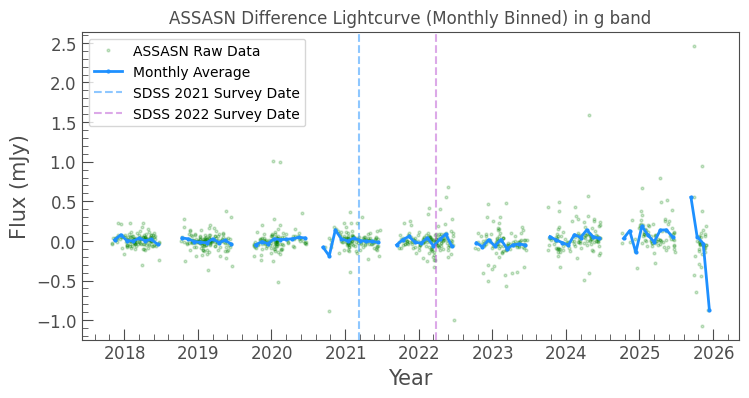

In [110]:
interval = 0.08328542094 # a month is on average 30.42 days - 30.42 / 365.25
ax = curve.plot(alpha=0.2, color='green', label='ASSASN Raw Data', linestyle='none', marker='o')
bin_curve = curve.bin(time_bin_size=interval) 

bin_curve.plot(ax=ax, color='dodgerblue', linewidth=2, marker='o', label='Monthly Average')

ax.set_title(f"ASSASN Difference Lightcurve (Monthly Binned) in {band1} band")
ax.set_xlabel("Year")
ax.set_ylabel("Flux (mJy)")
plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.legend()
plt.show()

This influences the binning algorithm. Thus we choose to clip point that are 3 sigma away to observe the binning effect in the g band

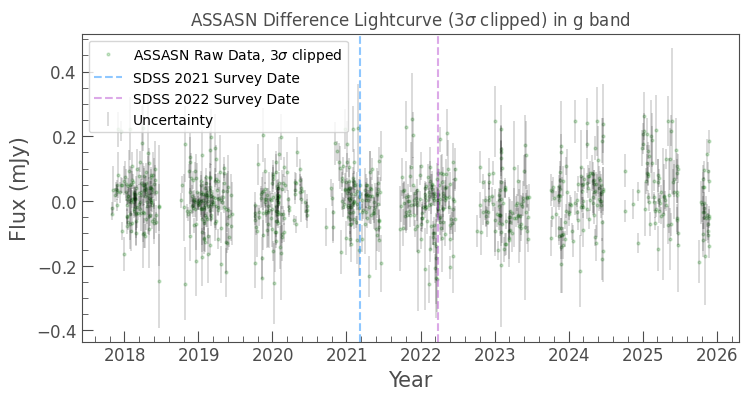

In [111]:
sigma = 3 # change this for tighter/looser clipping
clean_curve = curve.remove_outliers(sigma=sigma)
ax = clean_curve.plot(title=f"ASSASN Difference Lightcurve in {band1} band, {sigma} sigma clipped", alpha=0.2, color='green', label=f'ASSASN Raw Data, {sigma}$\sigma$ clipped', linestyle='none', marker='o')
clean_curve.errorbar(ax=ax, color='black', label='Uncertainty', fmt='o', markersize=0, lw=0.2)
ax.set_xlabel("Year")
ax.set_ylabel("Flux (mJy)")
ax.set_title(f"ASSASN Difference Lightcurve ({sigma}$\sigma$ clipped) in {band1} band")
plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.legend()
plt.show()

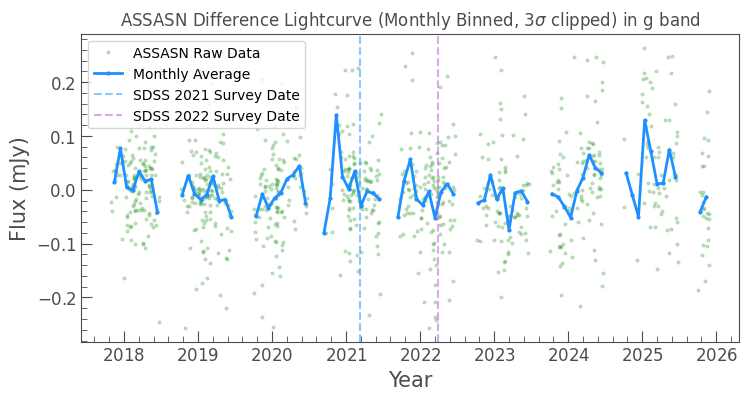

In [112]:
interval = 0.08328542094 # a month is on average 30.42 days - 30.42 / 365.25
ax = clean_curve.plot(alpha=0.2, color='green', label='ASSASN Raw Data', linestyle='none', marker='o')
bin_curve = clean_curve.bin(time_bin_size=interval) 

bin_curve.plot(ax=ax, color='dodgerblue', linewidth=2, marker='o', label='Monthly Average')

ax.set_title(f"ASSASN Difference Lightcurve (Monthly Binned, {sigma}$\sigma$ clipped) in {band1} band")
ax.set_xlabel("Year")
ax.set_ylabel("Flux (mJy)")
plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.legend()
plt.show()

We see far less unpredictable scatter, and a clear spike around 7th December 2020. This corresponds to a spontaneous amount of flux being received at this time. There is a subsequent decay not long after. Note the spike in flux near 2025 as well.

We now perform an SEM analysis, rather than relying on the extrinsic flux errors. The purpose of this is to convince ourselves that the spikes we are seeing are truly there, and not due to some other process

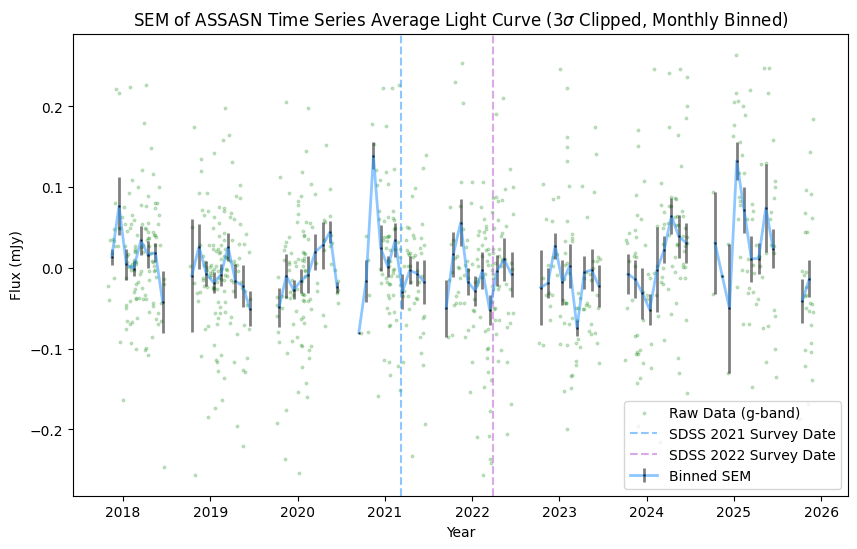

In [113]:
sigma = 3
bin_size = 30.42

lc_days = lk.LightCurve(time=subset1['HJD'], flux=subset1['flux(mJy)'], flux_err=subset1['flux_err'])
lc_clipped = lc_days.remove_outliers(sigma=sigma)
lc_binned = lc_clipped.bin(time_bin_size=bin_size)
lc_sem = lc_clipped.bin(time_bin_size=bin_size, aggregate_func=lambda x: sem(x, nan_policy='omit'))
lc_binned.flux_err = lc_sem.flux

raw_years = Time(lc_clipped.time.value, format='jd').decimalyear
binned_years = Time(lc_binned.time.value, format='jd').decimalyear

plt.figure(figsize=(10, 6))

plt.plot(raw_years, lc_clipped.flux.value, alpha=0.2, color='green', 
         marker='o', linestyle='none', label=f'Raw Data ({band1}-band)', markersize=1.9)

#plt.errorbar(binned_years, lc_binned.flux.value, yerr=lc_binned.flux_err.value, fmt='-o', markersize=0.9, lw=0.3, color='dodgerblue', ecolor='black', label='SEM') - old plotting code in case needed?

plt.errorbar(binned_years, lc_binned.flux.value, yerr=lc_binned.flux_err.value, fmt='-o', markersize=0.9, lw=2, color='dodgerblue', ecolor='black', alpha=0.5, mfc='black', mec='black', label='Binned SEM')

plt.title(f'SEM of ASSASN Time Series Average Light Curve ({sigma}$\sigma$ Clipped, Monthly Binned)')
plt.xlabel('Year')
plt.ylabel('Flux (mJy)')
plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.legend()
plt.show()

As we can see, the variation is not stochastic nor random noise - it is indeed an increase in flux during this epoch.

## ASSASN V band Lightcurve

We plot the ASSASN data in the V band

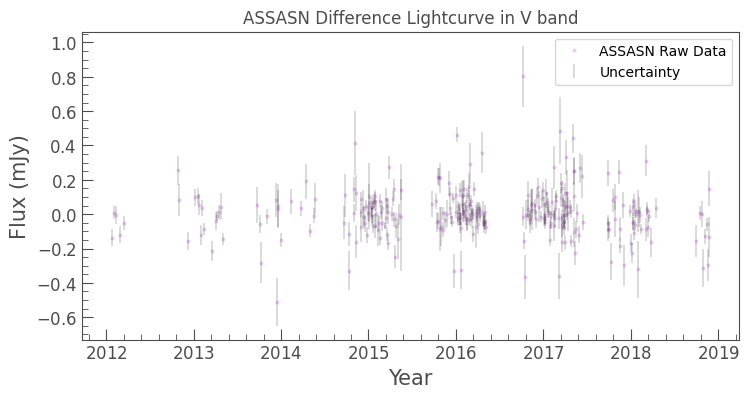

In [114]:
t_years = Time(subset2['HJD'], format='jd').decimalyear
curve = lk.LightCurve(time=t_years, flux=subset2['flux(mJy)'], flux_err=subset2['flux_err'])
ax = curve.plot(alpha=0.2, color='mediumorchid', label='ASSASN Raw Data', linestyle='none', marker='o')
curve.errorbar(ax=ax, color='black', label='Uncertainty', fmt='o', markersize=0, lw=0.2)
ax.set_xlabel("Year")
ax.set_ylabel("Flux (mJy)")
ax.set_title(f"ASSASN Difference Lightcurve in {band2} band")
plt.legend()
plt.show()

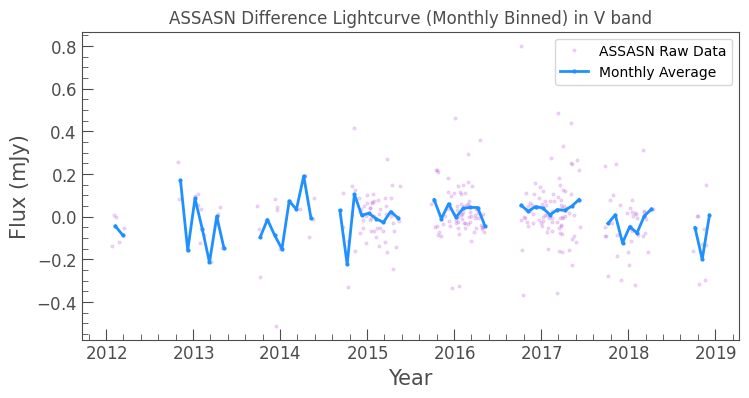

In [115]:
interval = 0.08328542094 # a month is on average 30.42 days - 30.42 / 365.25
ax = curve.plot(alpha=0.2, color='mediumorchid', label='ASSASN Raw Data', linestyle='none', marker='o')
bin_curve = curve.bin(time_bin_size=interval)

bin_curve.plot(ax=ax, color='dodgerblue', linewidth=2, marker='o', label='Monthly Average')

ax.set_title(f"ASSASN Difference Lightcurve (Monthly Binned) in {band2} band")
ax.set_xlabel("Year")
ax.set_ylabel("Flux (mJy)")
plt.legend()
plt.show()

We note that, in addition to the lack of data points (hence the unreliable binning early in the plot), the timescale on which the V band survey occurred only provides a rough baseline as to what SAMI 323854 looks like while quiet

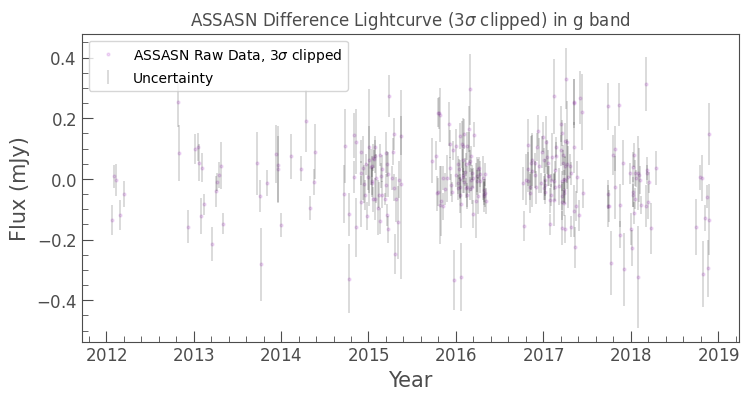

In [116]:
sigma = 3 # change this for tighter/looser clipping
clean_curve = curve.remove_outliers(sigma=sigma)
ax = clean_curve.plot(title=f"ASSASN Difference Lightcurve in {band2} band, {sigma} sigma clipped", alpha=0.2, color='mediumorchid', label=f'ASSASN Raw Data, {sigma}$\sigma$ clipped', linestyle='none', marker='o')
clean_curve.errorbar(ax=ax, color='black', label='Uncertainty', fmt='o', markersize=0, lw=0.2)
ax.set_xlabel("Year")
ax.set_ylabel("Flux (mJy)")
ax.set_title(f"ASSASN Difference Lightcurve ({sigma}$\sigma$ clipped) in {band1} band")
plt.legend()
plt.show()

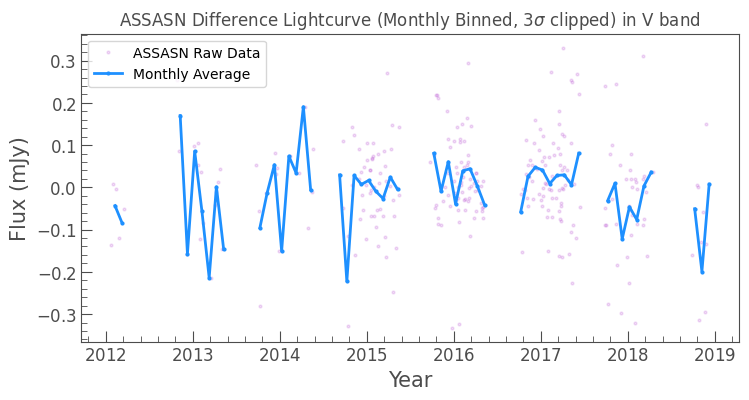

In [117]:
interval = 0.08328542094 # a month is on average 30.42 days - 30.42 / 365.25
ax = clean_curve.plot(alpha=0.2, color='mediumorchid', label='ASSASN Raw Data', linestyle='none', marker='o')
bin_curve = clean_curve.bin(time_bin_size=interval)
bin_curve.plot(ax=ax, color='dodgerblue', linewidth=2, marker='o', label='Monthly Average')

ax.set_title(f"ASSASN Difference Lightcurve (Monthly Binned, {sigma}$\sigma$ clipped) in {band2} band")
ax.set_xlabel("Year")
ax.set_ylabel("Flux (mJy)")
plt.legend()
plt.show()

Evidently, in the V band the baseline expectation is that the AGN is quiet, and the amount of $H_\alpha$ emission is minimal

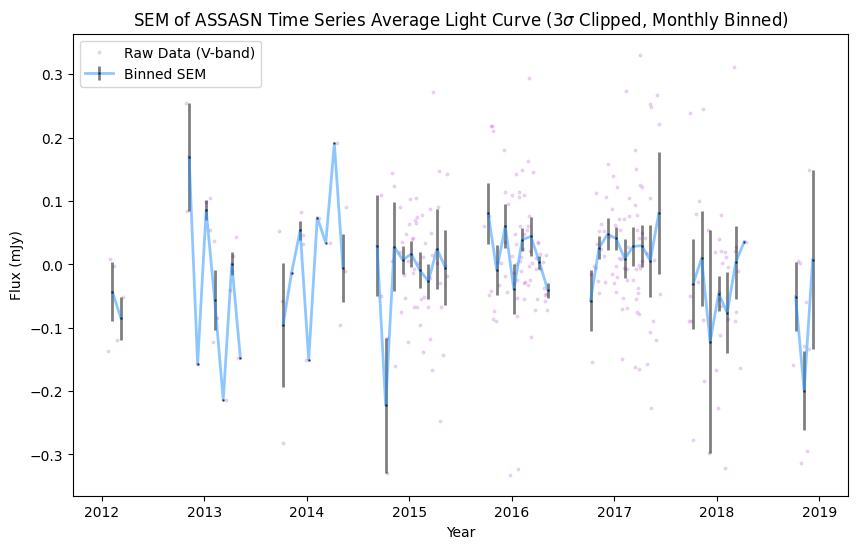

In [118]:
sigma = 3
bin_size = 30.42

lc_days = lk.LightCurve(time=subset2['HJD'], flux=subset2['flux(mJy)'], flux_err=subset2['flux_err'])
lc_clipped = lc_days.remove_outliers(sigma=sigma)
lc_binned = lc_clipped.bin(time_bin_size=bin_size)
lc_sem = lc_clipped.bin(time_bin_size=bin_size, aggregate_func=lambda x: sem(x, nan_policy='omit'))
lc_binned.flux_err = lc_sem.flux

raw_years = Time(lc_clipped.time.value, format='jd').decimalyear
binned_years = Time(lc_binned.time.value, format='jd').decimalyear

plt.figure(figsize=(10, 6))

plt.plot(raw_years, lc_clipped.flux.value, alpha=0.2, color='mediumorchid', 
         marker='o', linestyle='none', label=f'Raw Data ({band2}-band)', markersize=1.9)

#plt.errorbar(binned_years, lc_binned.flux.value, yerr=lc_binned.flux_err.value, fmt='-o', markersize=0.9, lw=0.3, color='dodgerblue', ecolor='black', label='SEM') - old plotting code in case needed?

plt.errorbar(binned_years, lc_binned.flux.value, yerr=lc_binned.flux_err.value, fmt='-o', markersize=0.9, lw=2, color='dodgerblue', ecolor='black', alpha=0.5, mfc='black', mec='black', label='Binned SEM')

plt.title(f'SEM of ASSASN Time Series Average Light Curve ({sigma}$\sigma$ Clipped, Monthly Binned)')
plt.xlabel('Year')
plt.ylabel('Flux (mJy)')
plt.legend()
plt.show()

Very little stochastic noise - appears to be random in this epoch. This indicates that the galaxy was quiet before in the V band, and ramps up unexpectedly in the g band in December 2020

## ATLAS o band Lightcurve

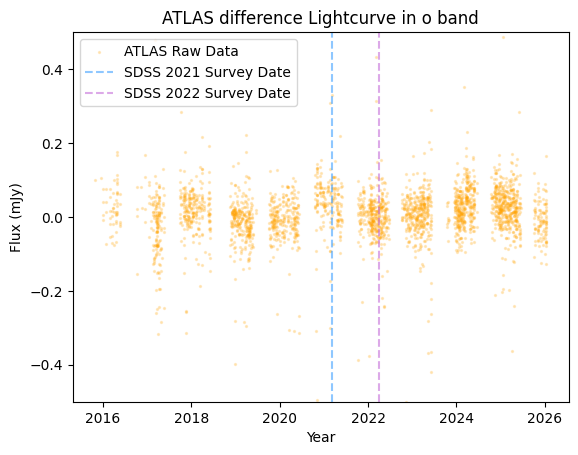

In [141]:
mjd = o_cat[:, 0].astype(float)
flux = o_cat[:, 3].astype(float) / 1000
flux_err = o_cat[:, 4].astype(float) / 1000 #div 1000 as it converts to millijanskys

sigma = 3

at_years = Time(mjd, format='mjd').decimalyear
plt.ylim(-0.5, 0.5)
plt.scatter(at_years, flux, alpha=0.2, color='orange',marker='o', label='ATLAS Raw Data', s=2.0)
plt.xlabel('Year')
plt.ylabel('Flux (mJy)')
plt.title(f"ATLAS difference Lightcurve in o band")
plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.legend()
plt.show()

The errors on ATLAS data are visually large and have been omitted, this is just the nature of the scaling on the plot.

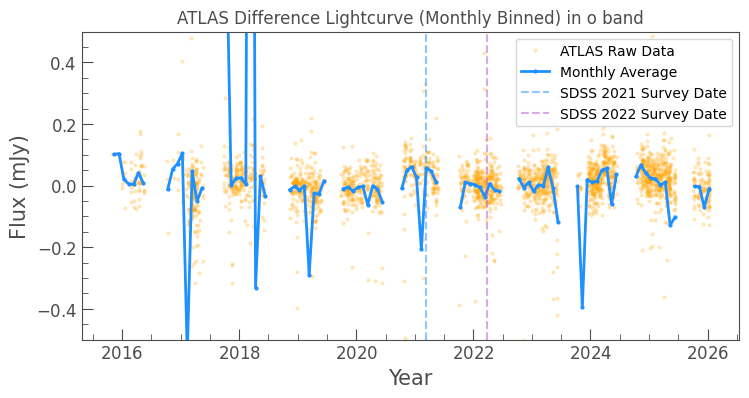

In [142]:
interval = 0.08328542094 # a month is on average 30.42 days - 30.42 / 365.25
atlas_lc = lk.LightCurve(time=at_years, flux=flux, flux_err=flux_err)
ax = atlas_lc.plot(alpha=0.2, color='orange',marker='o', linestyle='none', label='ATLAS Raw Data')
atlas_binned = atlas_lc.bin(time_bin_size=interval)
atlas_binned.plot(ax=ax, color='dodgerblue', linewidth=2, marker='o', label='Monthly Average')
plt.ylim(-0.5, 0.5)

ax.set_title("ATLAS Difference Lightcurve (Monthly Binned) in o band")
ax.set_ylabel("Flux (mJy)")
ax.set_xlabel("Year")
plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.legend()
plt.show()

Due to high errors, we require clipping in order to obtain useful results - we do this to 3 sigma

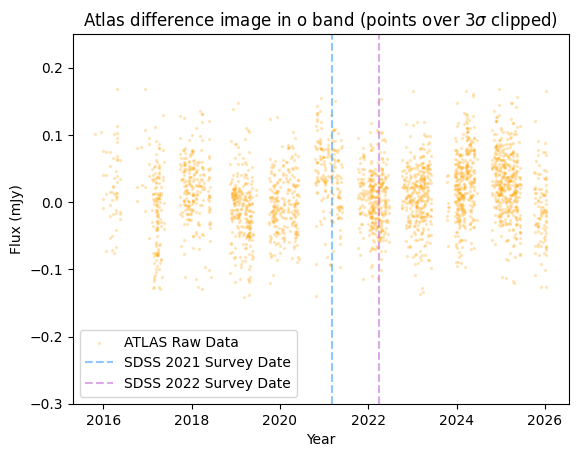

In [143]:
#index of band is 5

mjd = o_cat[:, 0].astype(float)
flux = o_cat[:, 3].astype(float) / 1000
flux_err = o_cat[:, 4].astype(float) / 1000 #div 1000 as it converts to millijanskys

sigma = 3

flux_clipped = sigma_clip(flux, sigma=sigma, maxiters=5)
n_mask = ~flux_clipped.mask
mjd_clean = mjd[n_mask]
flux_clean = flux[n_mask]
flux_err_clean = flux_err[n_mask]

at_years = Time(mjd_clean, format='mjd').decimalyear
plt.ylim(-0.5, 0.25)
plt.scatter(at_years, flux_clean, alpha=0.2, color='orange',marker='o', linestyle='None', label='ATLAS Raw Data', s=2.0)
plt.xlabel('Year')
plt.ylabel('Flux (mJy)')
plt.ylim(-0.3, 0.25)
plt.title(f"Atlas difference image in o band (points over {sigma}$\sigma$ clipped)")
plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.legend()
plt.show()

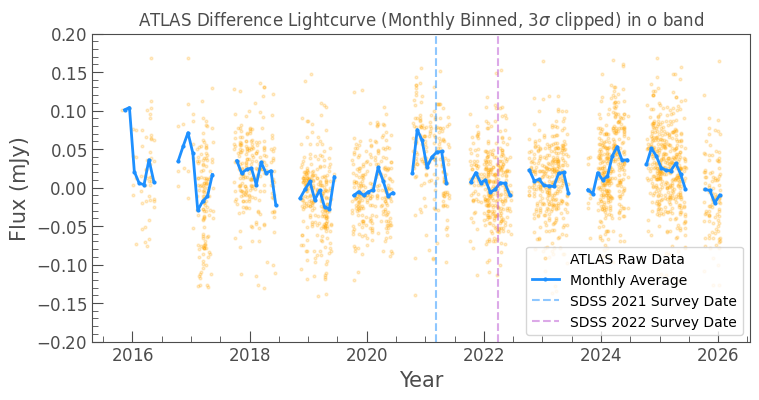

In [144]:
interval = 0.08328542094 # a month is on average 30.42 days - 30.42 / 365.25
atlas_lc = lk.LightCurve(time=at_years, flux=flux_clean, flux_err=flux_err_clean)
ax = atlas_lc.plot(alpha=0.2, color='orange',marker='o', linestyle='none', label='ATLAS Raw Data')
atlas_binned = atlas_lc.bin(time_bin_size=interval)
atlas_binned.plot(ax=ax, color='dodgerblue', linewidth=2, marker='o', label='Monthly Average')
plt.ylim(-0.2, 0.2)

ax.set_title(f"ATLAS Difference Lightcurve (Monthly Binned, {sigma}$\sigma$ clipped) in o band")
ax.set_ylabel("Flux (mJy)")
ax.set_xlabel("Year")
plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.legend()
plt.show()

The spike near 2020 is consistent with previous data. After checking error bars, it is apparent that the earlier spike is due to bad binning. We now perform SEM analysis.

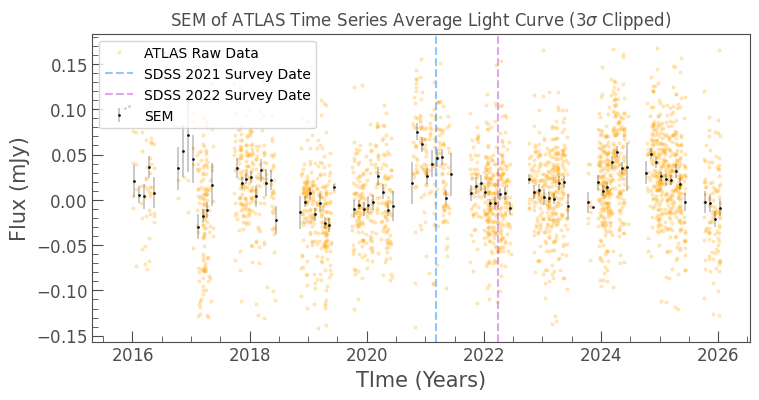

In [145]:
mjd = o_cat[:, 0].astype(float)
flux = o_cat[:, 3].astype(float) / 1000
flux_err = o_cat[:, 4].astype(float) / 1000

sigma = 3

flux_clipped = sigma_clip(flux, sigma=sigma, maxiters=5)
n_mask = ~flux_clipped.mask
mjd_clean = mjd[n_mask]
flux_clean = flux[n_mask]
flux_err_clean = flux_err[n_mask]

t_years = Time(mjd_clean, format='mjd').decimalyear

lc_clean = lk.LightCurve(time=mjd_clean, flux=flux_clean, flux_err=flux_err_clean)
atlas_lc = lk.LightCurve(time=t_years, flux=flux_clean, flux_err=flux_err_clean)

ax = atlas_lc.plot(alpha=0.2, color='orange',marker='o', linestyle='none', label='ATLAS Raw Data')

bin_size = 30.42 # because months are not exactly 30 days
lc_bined = lc_clean.bin(time_bin_size=bin_size)

lc_sem = lc_clean.bin(time_bin_size=bin_size, aggregate_func= lambda x: sem(x, nan_policy='omit'))

lc_bined.flux_err = lc_sem.flux

bin_years = Time(lc_bined.time.value, format='mjd').decimalyear
ax.errorbar(bin_years, lc_bined.flux.value, yerr=lc_bined.flux_err.value, fmt='o', markersize=0.9, lw=0.3, color='black', label='SEM')

plt.axvline(x=2021.186, label='SDSS 2021 Survey Date', color = 'dodgerblue', linestyle='dashed', alpha = 0.5)
plt.axvline(x=2022.238888888889, label='SDSS 2022 Survey Date', color = 'mediumorchid', linestyle='dashed', alpha = 0.5)
plt.title(f'SEM of ATLAS Time Series Average Light Curve ({sigma}$\sigma$ Clipped)')
plt.ylabel('Flux (mJy)')
plt.xlabel('TIme (Years)')
plt.legend()
plt.show()

This confirms that this spike is indeed an intrinsic change in the luminosity of the AGN, at least from the ATLAS survey